In [1]:
# PARAMS

NORMALIZE_STATE = True
NORMALIZE_ACTIONS = True

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys

sys.path.append('D:/projects/carball')

from tqdm.notebook import tqdm

import carball
from carball.controls.controls import ControlsCreator
from carball.json_parser import Game

# NN 
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

device = torch.device("cpu")

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)
#print (plt.rcParams.keys())

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Parse the game from a .replay file

In [5]:
def replayToGame(replayID):
    replayPath = os.path.join("replays", "%s.replay" % replayID)
    print ("Loading...\n\t%s" % replayPath)
    json = carball.decompile_replay(replayPath)
    game = Game()
    game.initialize(loaded_json=json)
    return game

GAME = replayToGame("noBoost1v1_1")
# Parses action-related properties into their actual actions
ControlsCreator().get_controls(GAME)

Loading...
	replays\noBoost1v1_1.replay


Could not find field_of_view in camera settings for Sundown
Could not find height in camera settings for Sundown
Could not find pitch in camera settings for Sundown
Could not find distance in camera settings for Sundown
Could not find stiffness in camera settings for Sundown
Could not find swivel_speed in camera settings for Sundown
Could not find transition_speed in camera settings for Sundown
D:/projects/carball\carball\controls\rotations.py:87: RuntimeWarning: invalid value encountered in sign
  rhs[1] / (T_p + np.sign(rhs[1]) * omega[1] * D_p),
D:/projects/carball\carball\controls\rotations.py:88: RuntimeWarning: invalid value encountered in sign
  rhs[2] / (T_y - np.sign(rhs[2]) * omega[2] * D_y)


In [6]:
nPlayers = len(GAME.players)
#assert nPlayers == 6, "Only 3v3 modes supported, this has %d players" % nPlayers
assert nPlayers == 2, "Only 1v1 modes supported, this has %d players" % nPlayers
print ("%d players loaded!" % nPlayers)

orangeIdx = [i for i, p in enumerate(GAME.players) if p.is_orange]
blueIdx = [i for i, p in enumerate(GAME.players) if not p.is_orange]

print ("\nOrange team:")
for i in orangeIdx:
    print ("\t%s" % GAME.players[i].name)
print ("\nBlue team:")
for i in blueIdx:
    print ("\t%s" % GAME.players[i].name)
        
nTimepoints = len(GAME.ball)
for p in GAME.players:
    assert len(p.data) >= nTimepoints - 20, \
        "Players (%d) need the same number of time points (%d), no leaves allowed" % (len(p.data), nTimepoints)
    nTimepoints = min(nTimepoints, len(p.data))
print ("\n%d data points acquired" % nTimepoints)

# if not all the same, trim
GAME.ball = GAME.ball.tail(nTimepoints)
for p in GAME.players:
    p.data = p.data.tail(nTimepoints)

2 players loaded!

Orange team:
	Sundown

Blue team:
	padster

12921 data points acquired


In [7]:
print ("Player values recorded:")
for pp in list(GAME.players[0].data):
    print (" * " + pp)
    
print ("\nBall values recorded:")
for bp in list(GAME.ball):
    print (" * " + bp)

Player values recorded:
 * ping
 * pos_x
 * pos_y
 * pos_z
 * rot_x
 * rot_y
 * rot_z
 * vel_x
 * vel_y
 * vel_z
 * ang_vel_x
 * ang_vel_y
 * ang_vel_z
 * throttle
 * steer
 * handbrake
 * ball_cam
 * boost
 * boost_active
 * jump_active
 * double_jump_active
 * dodge_active
 * boost_collect

Ball values recorded:
 * pos_x
 * pos_y
 * pos_z
 * rot_x
 * rot_y
 * rot_z
 * vel_x
 * vel_y
 * vel_z
 * ang_vel_x
 * ang_vel_y
 * ang_vel_z
 * hit_team_no


In [8]:
PLAYER_STATE_KEYS = (
    ['pos_x', 'pos_y', 'pos_z'] +              # x \
    ['vel_x', 'vel_y', 'vel_z'] +              # dx/xt \
    ['rot_x', 'rot_y', 'rot_z'] +              # q \
    ['ang_vel_x', 'ang_vel_y', 'ang_vel_z'] +  # dq/dt \
    ['boost']
)

PLAYER_ANALOG_ACTION_KEYS = ['throttle', 'steer']
PLAYER_DIGITAL_ACTION_KEYS = ['boost'] # Simplified easier case
#PLAYER_DIGITAL_ACTION_KEYS = ['boost', 'jump', 'handbreak'] # Harder case
PLAYER_ACTION_KEYS = PLAYER_ANALOG_ACTION_KEYS + PLAYER_DIGITAL_ACTION_KEYS

# Only useful state for ball is (x,y,z) position
BALL_STATE_KEYS = (
    ['pos_x', 'pos_y', 'pos_z']
)

def normMiddlePeak(v):
    return 4/(1 + np.exp(-v)) - 2
    #return np.cbrt(v)
    #return math.erf(v)
    
def ensure01(values):
    assert np.sum(values.isin([0, 1])) == len(values), "Boolean column is not just 0s and 1s"
    return values
    

def imputePlayerState(stateDF):
    # Note: Missing values come from start of game or after explosion, in which case, 
    # should be an okay approximation to impute by forward then backfilling.
    return stateDF.fillna(method='ffill').fillna(method='bfill')

def normPlayerState(stateDF):
    normedDF = pd.DataFrame()
    normedDF['pos_x'] = stateDF['pos_x'] / 4000.0
    normedDF['pos_y'] = stateDF['pos_y'] / 5500.0
    normedDF['pos_z'] = stateDF['pos_z'] / 2000.0
    normedDF['vel_x'] = normMiddlePeak(stateDF['vel_x'] / 22000.0)
    normedDF['vel_y'] = normMiddlePeak(stateDF['vel_y'] / 22000.0)
    normedDF['vel_z'] = normMiddlePeak(normMiddlePeak(stateDF['vel_z'] / 16000.0))
    normedDF['rot_x'] = normMiddlePeak(stateDF['rot_x'] / (np.pi / 2))
    normedDF['rot_y'] = stateDF['rot_y'] / np.pi
    normedDF['rot_z'] = normMiddlePeak(stateDF['rot_z'] / np.pi)
    normedDF['ang_vel_x'] = stateDF['ang_vel_x'] / 6000.0
    normedDF['ang_vel_y'] = stateDF['ang_vel_y'] / 6000.0
    normedDF['ang_vel_z'] = stateDF['ang_vel_z'] / 6000.0
    normedDF['boost'] = stateDF['boost'] / 256.0
    assert normedDF.shape[1] == stateDF.shape[1], "Columns are missing normalization"
    return normedDF

def imputePlayerActions(actionDF):
    # Missing value here are converted to inaction
    actionDF = actionDF.fillna({
        'throttle': 0,
        'steer': 0,
        'jump': False,
        'boost': False,
        'handbrake': False,
    })
    #actionDF = actionDF.astype({
    #    'jump': 'float64',               # from bool
    #    'boost': 'float64',              # from bool
    #    'handbrake': 'float64',          # from bool
    #})
    return actionDF

def normPlayerActions(actionDF):
    # Note: ControlsCreator already norms them for us
    normedDF = actionDF.copy()
    assert normedDF.shape[1] == actionDF.shape[1], "Columns are missing normalization"
    return normedDF

def normBallState(stateDF):
    normedDF = pd.DataFrame()
    normedDF['pos_x'] = stateDF['pos_x'] / 4000.0
    normedDF['pos_y'] = stateDF['pos_y'] / 5500.0
    normedDF['pos_z'] = stateDF['pos_z'] / 2000.0
    assert normedDF.shape[1] == stateDF.shape[1], "Columns are missing normalization"
    return normedDF

def cleanPlayerStates(playerDF):
    stateDF = playerDF[PLAYER_STATE_KEYS]
    stateDF = imputePlayerState(stateDF)
    if NORMALIZE_STATE:
        stateDF = normPlayerState(stateDF)
    return stateDF

def cleanPlayerActions(controlDF):
    actionDF = controlDF[PLAYER_ACTION_KEYS]
    actionDF = imputePlayerActions(actionDF)
    if NORMALIZE_ACTIONS:
        actionDF = normPlayerActions(actionDF)
    return actionDF

def cleanBallStates(ballDF):
    stateDF = ballDF[BALL_STATE_KEYS] * 1.0 # force int -> float
    if NORMALIZE_STATE:
        stateDF = normBallState(stateDF)
    return stateDF
    
playerStates, playerActions = [], []
for p in tqdm(GAME.players):
    playerStates.append( cleanPlayerStates( p.data))
    playerActions.append(cleanPlayerActions(p.controls))
ballStates = cleanBallStates(GAME.ball)

## Distrubutions of values

Histogram for the distribution of values of each state and columns

Player states:


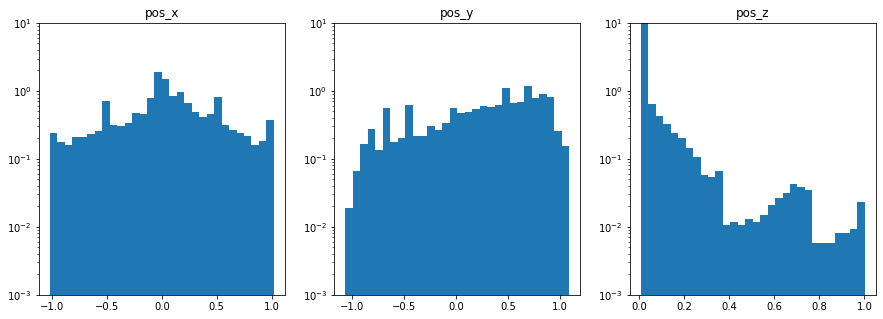

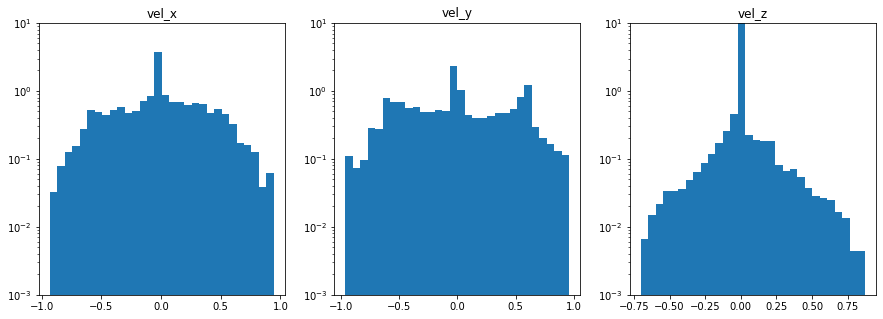

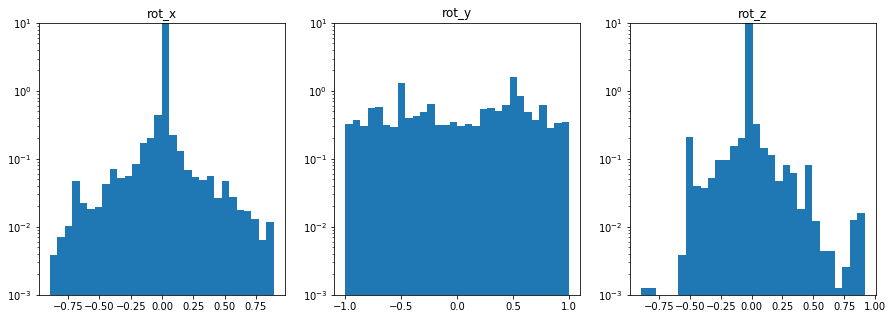

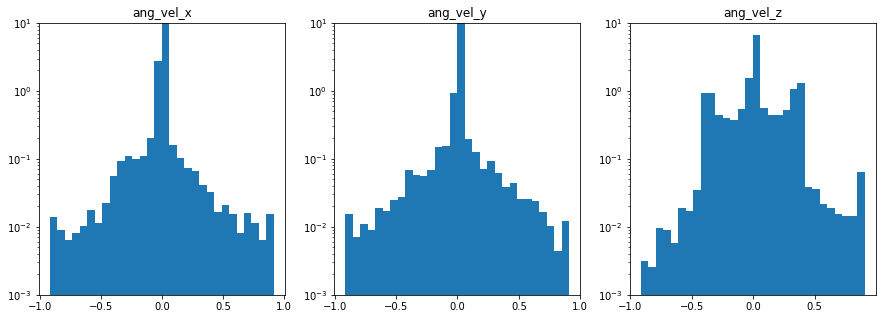

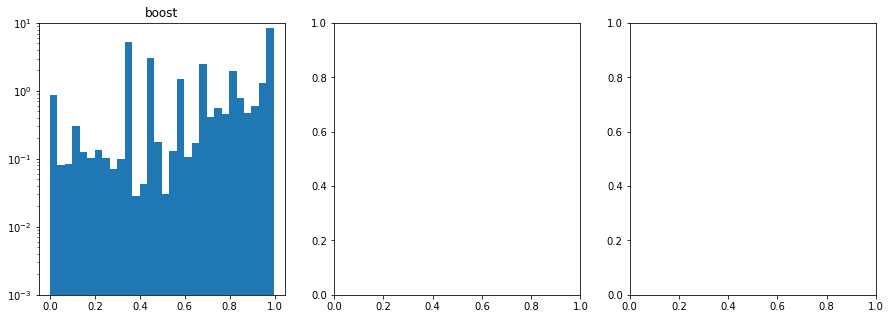

Player actions:


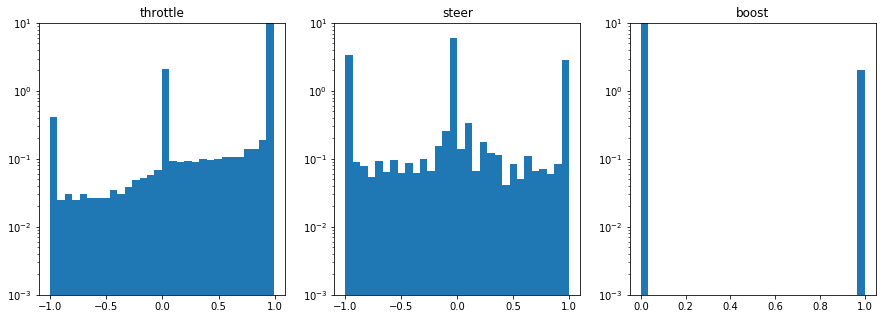

Ball states:


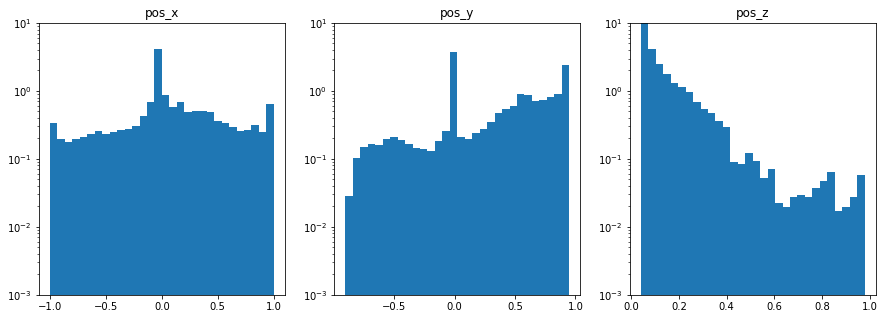

In [9]:
print ("Player states:")
for i in range(0, len(PLAYER_STATE_KEYS), 3):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for j in range(3):
        if i + j >= len(PLAYER_STATE_KEYS):
            break
        key = PLAYER_STATE_KEYS[i + j]
        allValues = []
        for pState in playerStates:
            allValues.extend(pState[key].values)
        ax[j].hist(allValues, log=True, bins=30, density=True)
        ax[j].set_title(key)
        ax[j].set_ylim((1e-3, 10))
    plt.show()

print ("Player actions:")
for i in range(0, len(PLAYER_ACTION_KEYS), 3):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for j in range(3):
        if i + j >= len(PLAYER_ACTION_KEYS):
            break
        key = PLAYER_ACTION_KEYS[i + j]
        allValues = []
        for pAct in playerActions:
            allValues.extend(pAct[key].values * 1.0)
        ax[j].hist(allValues, log=True, bins=30, density=True)
        ax[j].set_title(key)
        ax[j].set_ylim((1e-3, 10))
    plt.show()
    
print ("Ball states:")
for i in range(0, len(BALL_STATE_KEYS), 3):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for j in range(3):
        if i + j >= len(BALL_STATE_KEYS):
            break
        key = BALL_STATE_KEYS[i + j]
        allValues = ballStates[key].values
        ax[j].hist(allValues, log=True, bins=30, density=True)
        ax[j].set_title(key)
        ax[j].set_ylim((1e-3, 10))
    plt.show()

In [10]:
###

In [11]:
def copyIntoPrefixed(toDF, fromDF, prefix):
    for column in list(fromDF):
        toDF[prefix + column] = fromDF[column]

def teamBreakdown(playerIdx):
    isOrange = GAME.players[playerIdx].is_orange
    teamIdx = [i for i in range(nPlayers) if i != playerIdx and GAME.players[i].is_orange == isOrange]
    enemyIdx = blueIdx if isOrange else orangeIdx
    return teamIdx, enemyIdx 
    
def stateAndActionsForPlayer(playerIdx):
    stateDF = pd.DataFrame(index=ballStates.index)
    copyIntoPrefixed(stateDF, ballStates, "b_")
    copyIntoPrefixed(stateDF, playerStates[playerIdx], "me_")
    
    teamIdx, enemyIdx = teamBreakdown(playerIdx)
    for i, idx in enumerate(teamIdx):
        copyIntoPrefixed(stateDF, playerStates[idx], "t%d_" % i)
    for i, idx in enumerate(enemyIdx):
        copyIntoPrefixed(stateDF, playerStates[idx], "e%d_" % i)
    assert max(stateDF.isna().sum()) == 0, "NA state values not successfully removed?"
    
    actionDF = playerActions[playerIdx]
    assert max(actionDF.isna().sum()) == 0, "NA action values not successfully removed?"
    return stateDF, actionDF
    
P2S, P2A = stateAndActionsForPlayer(1)
print (P2S.values.shape, P2S.values.dtype)
print (P2A.values.shape, P2A.values.dtype)

(12921, 29) float64
(12921, 3) object


In [12]:
class MyModel(nn.Module):
    def __init__(self, state_size, action_analog_size, action_digital_size):
        super(MyModel, self).__init__()
        
        # Start with a super simple multi-layer perceptron, one hidden layer 
        self.dimH       = 32 # hidden layer has 16 dimensions
        self.dimIn         = state_size
        self.dimOutAnalog  = action_analog_size
        self.dimOutDigital = action_digital_size
        self.dimOut = action_analog_size + action_digital_size
     
        #self.inputToHidden = nn.Linear(self.dimIn, self.dimH)
        #self.hiddenToAnalog = nn.Linear(self.dimH, action_analog_size)
        #self.hiddenToDigitalPairs = nn.Linear(self.dimH, 2 * action_digital_size)

        self.model = torch.nn.Sequential(
           nn.Linear(self.dimIn, self.dimH),
           nn.ReLU(),
           nn.Linear(self.dimH, self.dimOut),
        )
        self.model.to(device)

    def forward(self, x):
        # input data type needs to be converted to float
        return self.model(x.float())
    
        #hidden = self.inputToHidden(x.float())
        #analogOut = self.hiddenToAnalog(hidden)
        #digitalPairs = self.hiddenToDigitalPairs(hidden)
        #pairsReshaped = digitalPairs.reshape([self.dimOutDigital, 2])
        #digitalOut = F.softmax(pairsReshaped, dim=1)[0]
        #return torch.cat((analogOut, digitalOut), dim=0)
        
    def save(self, modelID):
        path = os.path.join("models", "%s.pt" % modelID)
        torch.save(self.state_dict(), path)
        print('Saved model!\n\t%s' % path)
        
    def load(self, modelID):
        path = os.path.join("models", "%s.pt" % modelID)
        self.load_state_dict(torch.load(path))
        print('Loaded model!\n\t%s' % path)

In [13]:
TOTAL_EPOCHS = 40
BATCH_SZ = 100
#PRINT_INTERVAL = 1000
LOG_INTERVAL = 1000
LEARNING_RATE = 0.0001
REGULARIZER_WEIGHT = 3e-4

W_ALOSS = 100
W_DLOSS = 50

writer = SummaryWriter()

def train_behavioral_cloning(dataBatches, model):
    # Adam optimizer usually a good default.
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZER_WEIGHT)
    
    # MSE loss for [-1, 1] continuous variables:
    analog_loss_func = torch.nn.MSELoss().to(device)
    
    # Cross entropy loss for binary variables:
    digital_loss_func = torch.nn.BCEWithLogitsLoss().to(device)# weight=torch.tensor(1.0), pos_weight=torch.tensor(1.0)).to(device)

    gradient_steps = 0

    for epoch in range(1, TOTAL_EPOCHS + 1):
        batchShuffled = random.sample(dataBatches, len(dataBatches))
        lastLoss = -1
        for iteration, data in enumerate(batchShuffled):
            data = {k: v.to(device) for k, v in data.items()}
            #print (data)

            output = model(data['state'])
            analogAction = data['analogAction']
            digitalAction = data['digitalAction']
            aasz = len(PLAYER_ANALOG_ACTION_KEYS)

            #loss = loss_function(output, data["action"])
            aLoss = W_ALOSS * analog_loss_func(output[:aasz], analogAction)
            dLoss = W_DLOSS * digital_loss_func(output[aasz:], digitalAction)
            loss = aLoss + dLoss
            #print (aLoss, dLoss, loss)
            #loss = dLoss
            #print (output[aasz:], digitalAction)
            #print (loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #if gradient_steps % PRINT_INTERVAL == 0:
            #    print('[epoch {:4d}/{}] [iter {:7d}] [loss {:.5f}]'
            #        .format(epoch, TOTAL_EPOCHS, gradient_steps, loss.item()))
            if gradient_steps % LOG_INTERVAL == 0:
                writer.add_scalar('analogLoss', aLoss.item(), gradient_steps)
                writer.add_scalar('digitalLoss', dLoss.item(), gradient_steps)
                writer.add_scalar('loss', loss.item(), gradient_steps)
            
            gradient_steps += 1
            
            if iteration == len(batchShuffled) - 1:
                lastLoss = loss.item()
            
        print ('[epoch {:4d}/{}] [iter {:7d}] [loss {:.5f}]'.format(
           epoch, TOTAL_EPOCHS, gradient_steps, lastLoss)
        )

        #if epoch % TEST_INTERVAL == 0:
        #    score = eval_policy(policy=model, env=ENV_NAME)
        #    print('[Test on environment] [epoch {}/{}] [score {:.2f}]'
        #        .format(epoch, TOTAL_EPOCHS, score))


    # Force directory to be same as this file.
    #model_name = "behavioral_cloning_{}.pt".format(ENV_NAME)
    #fullPath = os.path.join(os.path.dirname(__file__), model_name)
    #torch.save(model.state_dict(), fullPath)
    #print('Saving model to {}'.format(fullPath))
    
    
random.seed(1234)
def dataToBatches(states, actions, batchSz, history):
    nRows = states.shape[0]
    stateSz = states.shape[1] * history
    actionAnalogSz = len(PLAYER_ANALOG_ACTION_KEYS)

    actionOrder = list(range(history, nRows))
    random.shuffle(actionOrder)
    
    dataBatches = []
    for i in range(0, len(actionOrder), batchSz):
        nInBatch = min(batchSz, len(actionOrder) - i)
        for j in range(nInBatch):
            actionAfter = actionOrder[i + j] # one after the time point we're predicting
            action = actions.iloc[actionAfter-1, :].values
            analogAction = action[:actionAnalogSz].astype(np.float32)
            if (len(np.where(np.isnan(analogAction))[0]) > 0):
                print ("BAD ACTION! ", actions.iloc[actionAfter-1, :])
            statesWithHistory = states.iloc[actionAfter - history:actionAfter, :].values.ravel()
            dataBatches.append({
                'state': torch.from_numpy(statesWithHistory).float(),
                'analogAction': torch.from_numpy(action[:actionAnalogSz].astype(np.float32)).float(),
                'digitalAction': torch.from_numpy(action[actionAnalogSz:].astype(np.bool)).float()
            })
            
    return dataBatches, stateSz, actionAnalogSz, len(PLAYER_DIGITAL_ACTION_KEYS)
    

def runTraining():    
    dataBatches, stateSz, actionAnalogSz, actionDigitalSize = dataToBatches(P2S, P2A, 50, 1)
    model = MyModel(stateSz, actionAnalogSz, actionDigitalSize)
    train_behavioral_cloning(dataBatches, model)
    model.save("boostOnly1v1")
    return model

model = runTraining()


[epoch    1/40] [iter   12920] [loss 1.41161]
[epoch    2/40] [iter   25840] [loss 18.23954]
[epoch    3/40] [iter   38760] [loss 7.33043]
[epoch    4/40] [iter   51680] [loss 10.19734]
[epoch    5/40] [iter   64600] [loss 19.69575]
[epoch    6/40] [iter   77520] [loss 45.95639]
[epoch    7/40] [iter   90440] [loss 1.19923]
[epoch    8/40] [iter  103360] [loss 0.80727]
[epoch    9/40] [iter  116280] [loss 0.84155]
[epoch   10/40] [iter  129200] [loss 96.99391]
[epoch   11/40] [iter  142120] [loss 2.22392]
[epoch   12/40] [iter  155040] [loss 0.59453]
[epoch   13/40] [iter  167960] [loss 62.77431]
[epoch   14/40] [iter  180880] [loss 38.01086]
[epoch   15/40] [iter  193800] [loss 1.58600]
[epoch   16/40] [iter  206720] [loss 60.67512]
[epoch   17/40] [iter  219640] [loss 18.93876]
[epoch   18/40] [iter  232560] [loss 36.17719]
[epoch   19/40] [iter  245480] [loss 41.29303]
[epoch   20/40] [iter  258400] [loss 6.06814]
[epoch   21/40] [iter  271320] [loss 40.54903]
[epoch   22/40] [iter 

In [14]:
print (list(P2S.head(1)))

['b_pos_x', 'b_pos_y', 'b_pos_z', 'me_pos_x', 'me_pos_y', 'me_pos_z', 'me_vel_x', 'me_vel_y', 'me_vel_z', 'me_rot_x', 'me_rot_y', 'me_rot_z', 'me_ang_vel_x', 'me_ang_vel_y', 'me_ang_vel_z', 'me_boost', 'e0_pos_x', 'e0_pos_y', 'e0_pos_z', 'e0_vel_x', 'e0_vel_y', 'e0_vel_z', 'e0_rot_x', 'e0_rot_y', 'e0_rot_z', 'e0_ang_vel_x', 'e0_ang_vel_y', 'e0_ang_vel_z', 'e0_boost']
